In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

train=pd.read_csv('Train.csv')
test=pd.read_csv('Test.csv')

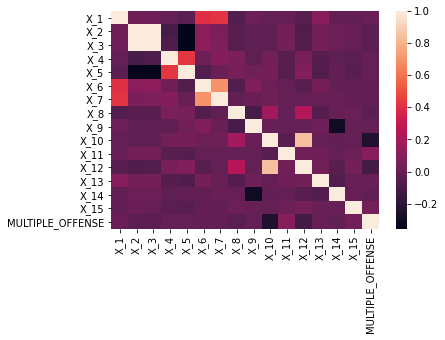

In [18]:

data = train.append(test, ignore_index=True,sort=False)

des=data.describe()

sns.heatmap(data.corr())

In [0]:



data["Date"] = data["DATE"].apply(lambda x: x[0:2])
data["Month"] = data["DATE"].apply(lambda x: x[3:6])
data["Year"] = data["DATE"].apply(lambda x: x[7:])


data["Month"]=data["Month"].map({"JAN" : '01' , "FEB" : '02' ,"MAR" : '03' ,"APR" : '04' ,"MAY" : '05' ,
              "JUN" : '06' ,"JUL" : '07' ,"AUG" : '08' ,"SEP" : '09' ,"OCT" : '10' ,"NOV" : '11',"DEC" : '12' })

def a(x):
    if x<="22":
        return "20"+x
    else:
        return "19"+x


data["Year2"]=data["Year"].apply(a)

In [0]:



data["Date2"]=data['Date'].map(str) + '-' + data['Month'].map(str) + '-' + data['Year2'].map(str)

data["Date2"] = pd.to_datetime(data["Date2"], format='%d-%m-%Y')

data['Dayofweek'] = pd.to_datetime(data['Date2']).dt.dayofweek

data['DayOfyear'] = pd.to_datetime(data['Date2']).dt.dayofyear

data['Week'] = pd.to_datetime(data['Date2']).dt.week

data['Quarter'] = pd.to_datetime(data['Date2']).dt.quarter 

data['Is_month_start'] = pd.to_datetime(data['Date2']).dt.is_month_start

data['Is_month_end'] = pd.to_datetime(data['Date2']).dt.is_month_end

data['Is_quarter_start'] = pd.to_datetime(data['Date2']).dt.is_quarter_start

data['Is_quarter_end'] = pd.to_datetime(data['Date2']).dt.is_quarter_end

data['Is_year_start'] = pd.to_datetime(data['Date2']).dt.is_year_start

data['Is_year_end'] = pd.to_datetime(data['Date2']).dt.is_year_end

data['Is_weekend'] = np.where(data['Dayofweek'].isin([5,6]),1,0)

data['Is_weekday'] = np.where(data['Dayofweek'].isin([0,1,2,3,4]),1,0)

data["Is_month_start"] = data["Is_month_start"].astype(int)
data["Is_month_end"] = data["Is_month_end"].astype(int)
data["Is_quarter_start"] = data["Is_quarter_start"].astype(int)
data["Is_quarter_end"] = data["Is_quarter_end"].astype(int)
data["Is_year_start"] = data["Is_year_start"].astype(int)
data["Is_year_end"] = data["Is_year_end"].astype(int)

In [0]:
data["X_12"].fillna(1,inplace =True)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39759 entries, 0 to 39758
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   INCIDENT_ID       39759 non-null  object        
 1   DATE              39759 non-null  object        
 2   X_1               39759 non-null  int64         
 3   X_2               39759 non-null  int64         
 4   X_3               39759 non-null  int64         
 5   X_4               39759 non-null  int64         
 6   X_5               39759 non-null  int64         
 7   X_6               39759 non-null  int64         
 8   X_7               39759 non-null  int64         
 9   X_8               39759 non-null  int64         
 10  X_9               39759 non-null  int64         
 11  X_10              39759 non-null  int64         
 12  X_11              39759 non-null  int64         
 13  X_12              39759 non-null  float64       
 14  X_13              3975

In [0]:

data.drop(columns=['INCIDENT_ID' , 'DATE' , 'Date2' , 'Year'] , inplace =True)


In [24]:

data["Month"] = data["Month"].astype('category')
data["Date"] = data["Date"].astype('category')
data["Year2"] = data["Year2"].astype('category')
x_test=data[23856:]
X_train=data[:23856]

Y_train=X_train["MULTIPLE_OFFENSE"].values

X_train.drop(columns="MULTIPLE_OFFENSE" , inplace =True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
len(x_test)

15903

In [0]:
   
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39759 entries, 0 to 39758
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   X_1               39759 non-null  int64   
 1   X_2               39759 non-null  int64   
 2   X_3               39759 non-null  int64   
 3   X_4               39759 non-null  int64   
 4   X_5               39759 non-null  int64   
 5   X_6               39759 non-null  int64   
 6   X_7               39759 non-null  int64   
 7   X_8               39759 non-null  int64   
 8   X_9               39759 non-null  int64   
 9   X_10              39759 non-null  int64   
 10  X_11              39759 non-null  int64   
 11  X_12              39759 non-null  float64 
 12  X_13              39759 non-null  int64   
 13  X_14              39759 non-null  int64   
 14  X_15              39759 non-null  int64   
 15  MULTIPLE_OFFENSE  23856 non-null  float64 
 16  Date              3975

In [28]:

kfold, scores = KFold(n_splits=5, shuffle=True, random_state=0), list()
for train_index, test_index in kfold.split(X_train,Y_train):
    x_train, x_test =X_train.iloc[train_index], X_train.iloc[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]
    
    num_class1, num_class2 = Counter(y_train)[1], Counter(y_train)[0]
    sm = SMOTE(random_state=27, sampling_strategy={1: int(1.0*num_class1), 0: int(2.0*num_class2)})
    x_train, y_train = sm.fit_resample(x_train, y_train)
    model = LGBMClassifier(random_state=27, max_depth=6, n_estimators=400)
    model.fit(x_train, y_train,  categorical_feature=[18, 16, 17])
    preds = model.predict(x_test)
    score = f1_score(y_test, preds, average="weighted")
    scores.append(score)
    print(score)
print("Average: ", sum(scores)/len(scores))



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [16, 17, 18]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0.9995818082053569


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [16, 17, 18]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0.9987363255121945


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [16, 17, 18]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0.9997906569133391


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [16, 17, 18]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0.9989530956586027


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [16, 17, 18]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0.9993718483789663
Average:  0.999286746933692


In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   X_1               23856 non-null  int64   
 1   X_2               23856 non-null  int64   
 2   X_3               23856 non-null  int64   
 3   X_4               23856 non-null  int64   
 4   X_5               23856 non-null  int64   
 5   X_6               23856 non-null  int64   
 6   X_7               23856 non-null  int64   
 7   X_8               23856 non-null  int64   
 8   X_9               23856 non-null  int64   
 9   X_10              23856 non-null  int64   
 10  X_11              23856 non-null  int64   
 11  X_12              23856 non-null  float64 
 12  X_13              23856 non-null  int64   
 13  X_14              23856 non-null  int64   
 14  X_15              23856 non-null  int64   
 15  Date              23856 non-null  category
 16  Month             2385

In [31]:
x_test=data[23856:]

x_test.drop(columns="MULTIPLE_OFFENSE" , inplace =True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [32]:
model = LGBMClassifier(random_state=27, n_estimators=1000, max_depth=4, verbose=500)
model.fit(X_train, Y_train, categorical_feature=[18, 17, 16])
preds1 = model.predict(x_test)


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [16, 17, 18]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [0]:
np.unique(preds1)
(unique, counts) = np.unique(preds1, return_counts=True)
frequencies = np.asarray((unique, counts)).T



In [0]:

final=pd.DataFrame()
final['INCIDENT_ID'] = test['INCIDENT_ID']
final['MULTIPLE_OFFENSE'] = preds1

final.to_csv('solution_1.csv', index=False)

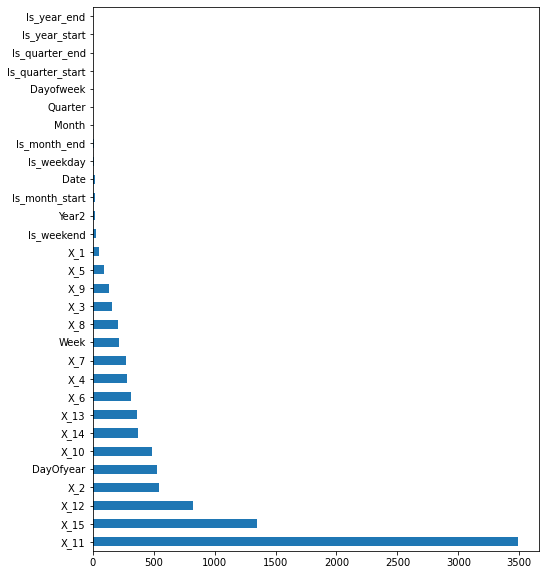

In [35]:
feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))
